# A time series model for International Visitors to NYC

### Module imports and reading in the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [4]:
visitors=pd.read_excel('../../../Desktop/Data Science Final Project/Monthly arrivals/International Visitors to NYC.xls')

In [5]:
visitors['Year and Month'] = pd.to_datetime(visitors['Year and Month'])
visitors.set_index('Year and Month', inplace=True)
visitors.head()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate
Year and Month,,,,
2007-01-01,296193,2007,1,1.299218
2007-02-01,311727,2007,2,1.307155
2007-03-01,418833,2007,3,1.323835
2007-04-01,451262,2007,4,1.349975
2007-05-01,437930,2007,5,1.351307


### Testing the time series for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 


#### Note: The rule of thumb is that if the Test Statistic is less than the Critical Value, we can say that the series is stationary.

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


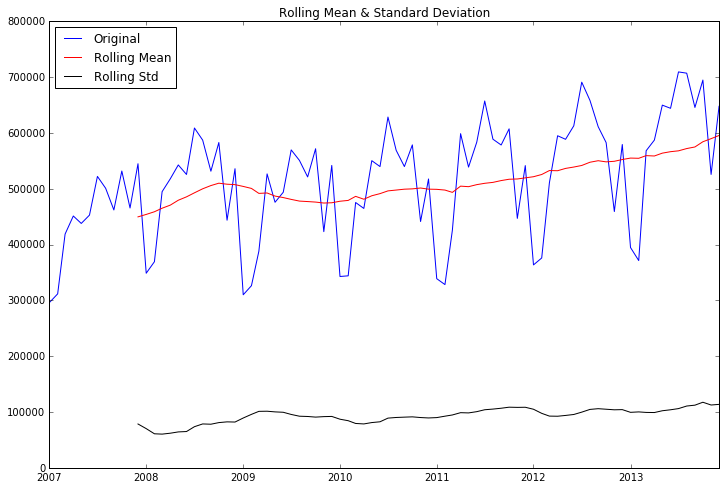

Results of Dickey-Fuller Test:
Test Statistic                  0.543765
p-value                         0.986144
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (5%)            -2.903200
Critical Value (1%)            -3.526005
Critical Value (10%)           -2.588995
dtype: float64


In [8]:
test_stationarity(visitors['International Visitors'])

#### -As we see above,the Test Statistic is significantly large than the Critical Values at differe confidence levels.
#### The visualization also shows a clear trend as well, which means the series is not stationary.

### Using differencing to detrend the series and create stationarity

#### -Now we will use a difference of 1 lag to try and reach a stationary series.

In [9]:
visitors['First difference']=visitors['International Visitors']-visitors['International Visitors'].shift(1)

/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/mikaelroussel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


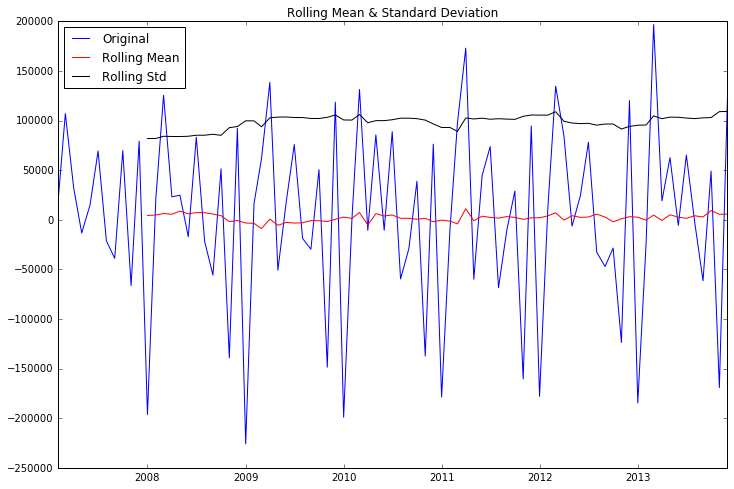

Results of Dickey-Fuller Test:
Test Statistic                 -2.241042
p-value                         0.191688
#Lags Used                     12.000000
Number of Observations Used    70.000000
Critical Value (5%)            -2.903811
Critical Value (1%)            -3.527426
Critical Value (10%)           -2.589320
dtype: float64


In [10]:
test_stationarity(visitors['First difference'].dropna(inplace=False))

#### In the Dickey-Fuller test on values from the series with a difference of 1 prior row,the Test Statistic has gotten much closer to the Critical Values.
#### The visualization also shows that the trend has leveled out and there is now a consistent mean throughout the series, which means the series seems to be stationary.

In [11]:
import statsmodels.api as sm

#### According to the Duke University source I used, the First difference is good enough because the first lag autocorrelation is already negative (see below). The mean has also leveled out. If we use more differencing, we could have overdifferencing.

#### Therefore I have an order of 1 differencing because I only needed to do one differencing in order to achieve the needed stationarity.

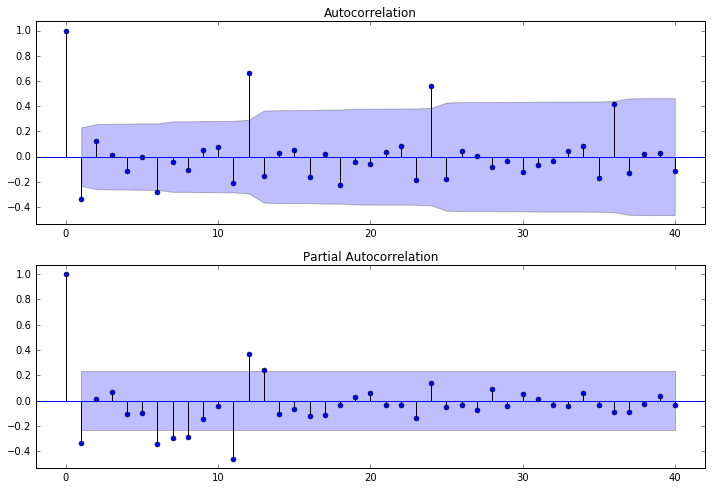

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(visitors['First difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(visitors['First difference'].iloc[13:], lags=40, ax=ax2)

#### Looking at the Autocorrelation and Partial Autocorrelation plots(above) is another way of determining if the transformations
#### have created enough stationarity. In this case they have.

In [13]:
import statsmodels.api as sm

### Setting the train and test parts:

#### Note: I put in this code to show that I attempted to use a train and test model for SARIMAX, but I wasn't able to use these. I therefore had to use the whole time series to fit the model.

In [14]:
n = len(visitors[['International Visitors']])

train = visitors['International Visitors'][:int(.75*n)]
test = visitors['International Visitors'][int(.75*n):]

In [15]:
train=train.map(lambda x: x+0.0)
train.shape

(63,)

In [16]:
test=test.map(lambda x: x+0.0)
test.head()

Year and Month
2012-04-01    595079.0
2012-05-01    588703.0
2012-06-01    612899.0
2012-07-01    691125.0
2012-08-01    658443.0
Name: International Visitors, dtype: float64

### Using the SARIMAX model

#### The model below with its parameters produced the best results of the different ones I tried. The Duke University source I used also recommended using an MA model if the stationarized series produced a negative autocorrelation at lag of 1. Since I observed this in my stationarized time series, it made sense to use the MA(1) model.

In [33]:
#order is same thing as p,d,q from ARIMA
mod = sm.tsa.SARIMAX(visitors['International Visitors'], trend='n', order=(0,1,1), seasonal_order=(1,1,0,12),enforce_invertibility=False)
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:             International Visitors   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -862.149
Date:                            Tue, 06 Dec 2016   AIC                           1730.298
Time:                                    16:05:25   BIC                           1737.591
Sample:                                01-01-2007   HQIC                          1733.230
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2834      0.035     -8.028      0.000      -0.353      -0.214
ar.S.L12      -0.1767      0.029   

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
predictions = results.predict(
    '2010-07-01',
    '2013-12-01 ',
    dynamic=True, 
)
print("Mean absolute error: ", mean_absolute_error(visitors['International Visitors'].iloc[42:], predictions))

('Mean absolute error: ', 33971.606990150372)


### Making forecasts:

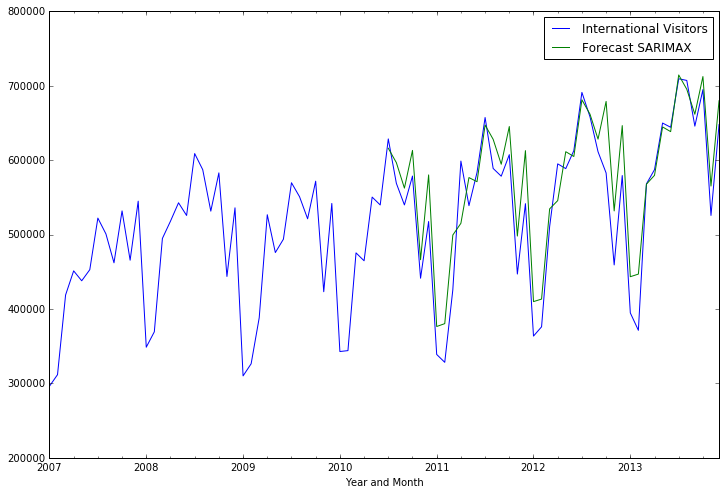

In [36]:
#I only get good predictions if I predict later rows in time series
visitors['Forecast SARIMAX'] = results.predict(start = 42, end= 84, dynamic= True)  
visitors[['International Visitors', 'Forecast SARIMAX']].plot(figsize=(12, 8))

### Using simple ARIMA model:

In [37]:
from sklearn.metrics import mean_absolute_error

In [40]:
model = sm.tsa.ARIMA(visitors['International Visitors'].map(lambda x: x+0.0), (0, 1, 1)).fit()

In [41]:
predictions = model.predict(
    start = 42, end= 83,
    dynamic=True, 
)
print("Mean absolute error: ", mean_absolute_error(visitors['International Visitors'].iloc[42:], predictions))
model.summary()

('Mean absolute error: ', 550310.31506779999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D.International Visitors   No. Observations:                   83
Model:                       ARIMA(0, 1, 1)   Log Likelihood               -1062.082
Method:                             css-mle   S.D. of innovations          87251.837
Date:                      Tue, 06 Dec 2016   AIC                           2130.165
Time:                              16:06:21   BIC                           2137.421
Sample:                          02-01-2007   HQIC                          2133.080
                               - 12-01-2013                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           4236.9398   6491.584      0.653      0.516   -8486.330     1.7e+04
ma.L1.D.International Visitors    -0.3267      0.105     -3.121      0.002      -0.532      -0.122
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            3.0605           +0.0000j            3.0605            0.0000
-----------------------------------------------------------------------------
"""

In [42]:
visitors.head()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate,First difference,Forecast SARIMAX
Year and Month,,,,,,
2007-01-01,296193,2007,1,1.299218,NaN,NaN
2007-02-01,311727,2007,2,1.307155,15534.0,NaN
2007-03-01,418833,2007,3,1.323835,107106.0,NaN
2007-04-01,451262,2007,4,1.349975,32429.0,NaN
2007-05-01,437930,2007,5,1.351307,-13332.0,NaN


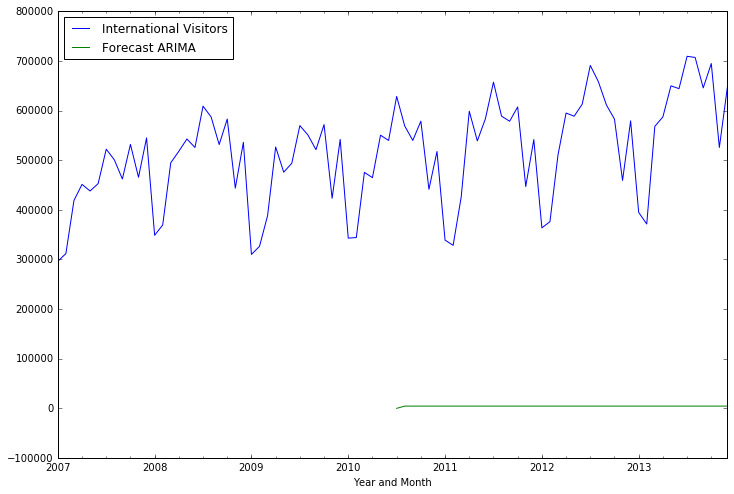

In [43]:
visitors['Forecast ARIMA'] = model.predict(start = 42, end= 84, dynamic= True)  
visitors[['International Visitors', 'Forecast ARIMA']].plot(figsize=(12, 8))

### Using AR model:



In [44]:
model = sm.tsa.ARIMA(visitors['International Visitors'].map(lambda x: x+0.0), (1, 0, 0)).fit()

In [46]:
predictions = model.predict(
    start = 42, end= 83,
    dynamic=True, 
)
print("Mean absolute error: ", mean_absolute_error(visitors['International Visitors'].iloc[42:], predictions))
model.summary()

('Mean absolute error: ', 94796.916210510186)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     International Visitors   No. Observations:                   84
Model:                         ARMA(1, 0)   Log Likelihood               -1071.216
Method:                           css-mle   S.D. of innovations          83366.193
Date:                    Tue, 06 Dec 2016   AIC                           2148.432
Time:                            16:08:22   BIC                           2155.725
Sample:                        01-01-2007   HQIC                          2151.364
                             - 12-01-2013                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.184e+05   2.24e+04     23.188      0.000    4.75e+05    5.62e+05
ar.L1.International Visitors     0.5983      0.091      6.556      0.000       0.419       0.777
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6714           +0.0000j            1.6714            0.0000
-----------------------------------------------------------------------------
"""

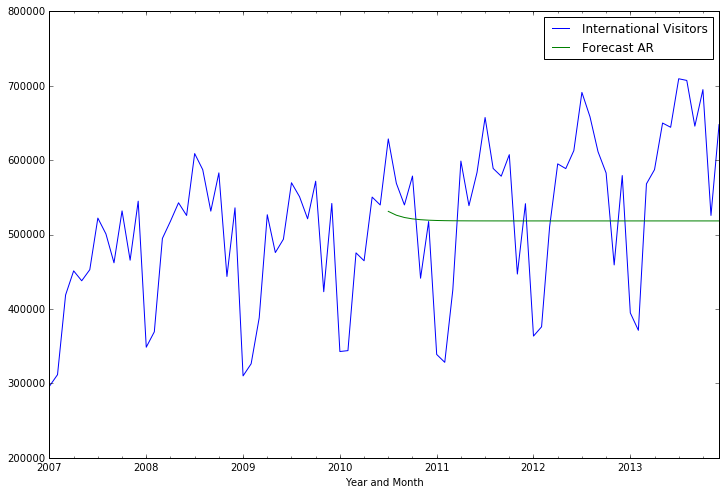

In [47]:
visitors['Forecast AR'] = model.predict(start = 42, end= 84, dynamic= True)  
visitors[['International Visitors', 'Forecast AR']].plot(figsize=(12, 8))

### Using MA model:

In [48]:
model = sm.tsa.ARIMA(visitors['International Visitors'].map(lambda x: x+0.0), (0, 0, 1)).fit()

In [50]:
predictions = model.predict(
    start = 42, end= 83,
    dynamic=True, 
)
print("Mean absolute error: ", mean_absolute_error(visitors['International Visitors'].iloc[42:], predictions))
model.summary()

('Mean absolute error: ', 97332.383191673871)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     International Visitors   No. Observations:                   84
Model:                         ARMA(0, 1)   Log Likelihood               -1077.773
Method:                           css-mle   S.D. of innovations          90266.082
Date:                    Tue, 06 Dec 2016   AIC                           2161.546
Time:                            16:09:19   BIC                           2168.839
Sample:                        01-01-2007   HQIC                          2164.478
                             - 12-01-2013                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.142e+05    1.4e+04     36.798      0.000    4.87e+05    5.42e+05
ma.L1.International Visitors     0.4237      0.085      4.992      0.000       0.257       0.590
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.3602           +0.0000j            2.3602            0.5000
-----------------------------------------------------------------------------
"""

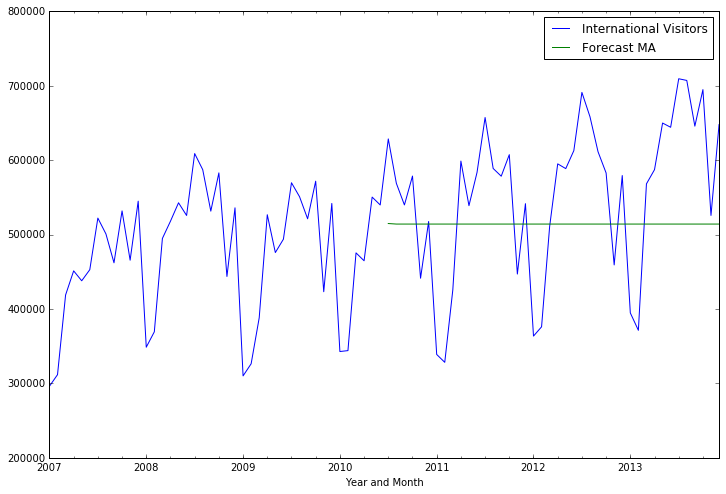

In [51]:
visitors['Forecast MA'] = model.predict(start = 42, end= 84, dynamic= True)  
visitors[['International Visitors', 'Forecast MA']].plot(figsize=(12, 8))

In [55]:
visitors.describe()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate,First difference,Forecast SARIMAX,Forecast ARIMA,Forecast AR,Forecast MA
count,84.000000,84.000000,84.000000,84.000000,83.000000,42.000000,42.000000,42.000000,42.000000
mean,514164.476190,2010.000000,6.500000,1.367088,4236.939759,578074.781872,4128.708742,519143.748016,514181.651955
std,103142.040168,2.012012,3.472786,0.080824,92995.809668,90297.958193,701.417151,2380.907098,111.311684
min,296193.000000,2007.000000,1.000000,1.221578,-225922.000000,376463.437641,-308.762918,518382.772694,514164.476189
25%,446171.500000,2008.000000,3.750000,1.307376,NaN,NaN,NaN,NaN,NaN
50%,531698.000000,2010.000000,6.500000,1.350519,NaN,NaN,NaN,NaN,NaN
75%,584491.250000,2012.000000,9.250000,1.426265,NaN,NaN,NaN,NaN,NaN
max,709465.000000,2013.000000,12.000000,1.576778,196813.000000,714571.861484,4236.939758,531221.693212,514885.858351


## Summary of different models

#### The model that performed by far the best was the SARIMAX model with the parameters indicated above. The reason it did so well because it was able to capture the seasonal pattern and year over year positive trend.

## Predicting future values

In [56]:
import dateutil

In [57]:
start = pd.datetime.strptime("2014-01-01", "%Y-%m-%d")
date_list = [start + dateutil.relativedelta.relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= visitors.columns)
visitors = pd.concat([visitors, future])

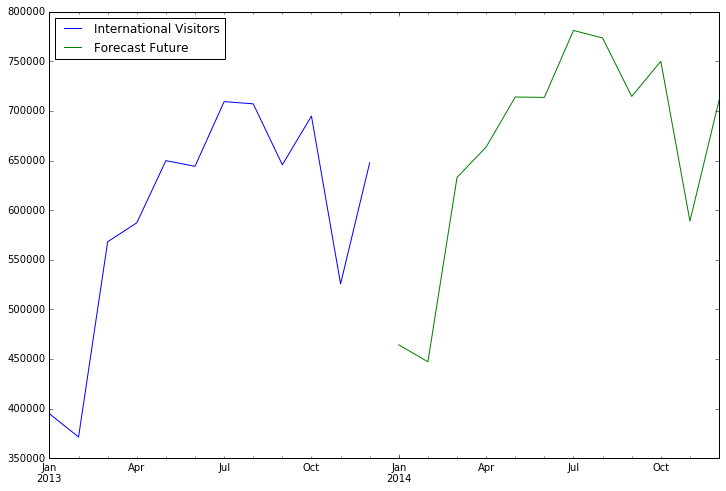

In [66]:
visitors['Forecast Future'] = results.predict(start = 84, end = 97, dynamic= True)  
visitors[['International Visitors', 'Forecast Future']].ix[-24:].plot(figsize=(12, 8)) 

In [67]:
visitors.tail()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate,First difference,Forecast SARIMAX,Forecast ARIMA,Forecast AR,Forecast MA,Forecast Future
2014-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,773585.688523
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,714691.685401
2014-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,750080.730623
2014-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,588983.153120
2014-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710751.459031


In [68]:
pd.groupby(visitors,by=[visitors.index.year]).sum()

,International Visitors,Year,Month,EUR/USD average monthly exchange rate,First difference,Forecast SARIMAX,Forecast ARIMA,Forecast AR,Forecast MA,Forecast Future
2007,5396428.0,24084.0,78.0,16.440934,248739.0,NaN,NaN,NaN,NaN,NaN
2008,6089745.0,24096.0,78.0,17.655036,-8942.0,NaN,NaN,NaN,NaN,NaN
2009,5699777.0,24108.0,78.0,16.725662,5884.0,NaN,NaN,NaN,NaN,NaN
2010,5992475.0,24120.0,78.0,15.930068,-24262.0,3.434951e+06,20875.935871,3.140792e+06,3.085708e+06,NaN
2011,6235139.0,24132.0,78.0,16.710897,23963.0,6.545254e+06,50843.277094,6.222056e+06,6.169974e+06,NaN
2012,6629472.0,24144.0,78.0,15.433713,37808.0,6.948685e+06,50843.277094,6.220596e+06,6.169974e+06,NaN
2013,7146780.0,24156.0,78.0,15.939070,68476.0,7.350251e+06,50843.277094,6.220593e+06,6.169974e+06,NaN
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955288e+06



## Total forecasted number for 2014 :7,955,288

## Total actual number for 2014: 7,895,074

## Difference of 60,214

### Note: After 2014 I could not find data that showed monthly international arrivals for NYC airports (JFK and Newark). The yearly total for NYC airports however shows that the year over year positive trend continued, and the SARIMAX model was able to capture that to predict total 2014 number that was very close to the real figure.